In [9]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
import time
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

In [10]:
"""Subtractive Clustering Algorithm
"""

def SubstractiveClustering(data, Ra, Rb, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)

    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]

    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])
        restarP = True
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else:
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

In [11]:
"""
Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.
"""


def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))



class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma





class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        #x = np.linspace(self.minValue -400,self.maxValue + 400,30)

        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)


# Se genera la clase Fis (sugeno)
class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        self.solutions=[]


    
    def genfis(self, data, labels, cluster_center):

        start_time = time.time()
        #labels, cluster_center = SubstactiveClustering(data, radii) se quita porque el clustering lo hacemos afuera para hacerlo variar a nuestro criterio
        
        n_clusters = len(cluster_center)
        cluster_center = cluster_center[:,:-1]

        varInput = data[:,:-1]

        #T = data[:,-1]
        maxValue = np.max(varInput, axis=0)
        minValue = np.min(varInput, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        varInput = data[:,:-1] #hace esa anotacion fea porque porque queda mejor los datos presentados
        varOuput = data[:,-1]
        

       #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs]) 
        f = [np.prod(gaussmf(varInput,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        varInput = np.c_[varInput, np.ones(len(varInput))]
        n_vars = varInput.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = varInput[:, orden]
        A = acti*inp/sumMu

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        solutions, residuals, rank, s = np.linalg.lstsq(A,varOuput,rcond=None)
        self.solutions = solutions
        print(solutions)
        return 0


###############################################################################################################
    
    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)

#################################################################################################################

    def viewInputs(self):
        for input in self.inputs:
            input.view()

In [40]:
#funcion de automatizacion
def automation(data_x,data_y,test_size,Ra,Rb): #Parametros division de datos data,test_size; clustering substractivo Ra,Rb; 
    '''                                 DIVISION DE LOS DATOS                              '''
    vda_entrenamiento, vda_esperados, tiempo_entrenamiento, tiempo_prueba = train_test_split(data_y, data_x, test_size=test_size, random_state=10) #random_state modifica la distancia entre los puntos que tomo para test.
    dataTrain = np.hstack((tiempo_entrenamiento,vda_entrenamiento)) # datos de entrenamiento
    dataTest = np.hstack((tiempo_prueba,vda_esperados)) # datos testing
    '''                                 CLUSTERING SUSTRACTIVO                             '''
    labels,centers = SubstractiveClustering(dataTrain,Ra,Rb) 
    plt.figure()
    plt.title(label='Clustering sustractivo para Ra={}'.format(Ra))
    plt.scatter(dataTrain[:,0],dataTrain[:,1],c=labels, s=7,label='datos train')
    plt.scatter(centers[:,0],centers[:,1], marker='X',s=20,c="black", label='clusters')
    plt.legend()
    plt.show()
    '''                                 SUGENO                                             '''
    fis2 = fis() # genero la clase fis, mejor llamado modelo de Sugeno
    fis2.genfis(dataTrain,labels,centers)
    fis2.viewInputs()

    '''                                 MODULO DE GRAFICO DE FUNCION SOLUCION DE SUGENO CON DATOS DE ENTRENAMIENTO                          '''
    
    maxValue =int(np.max(data_x))
    arreglo = np.linspace(1,maxValue,maxValue)                            #Generamos un arreglo con numeros del 1 al 350 para el eje x a graficar
    arreglo = arreglo.reshape(-1,1)
    coordenadas_y= fis2.evalfis(arreglo)                          #Generamos los valores del eje y a partir de la funcion solucion obtenida
   

    '''                                 MODULO DE VALIDACION Y CALCULO DE ERRORES                         datos_obtenidos '''
    errores = []
    resultado_obtenido = fis2.evalfis((tiempo_prueba))

    for i in range(len(resultado_obtenido)):
        resultado = resultado_obtenido[i] - vda_esperados[i]
        print(f" error en ierror{i}, error:  {resultado} , resultado_obtenido = {resultado_obtenido[i]}, resultado_esperado = {vda_esperados[i]}")
        errores.append(resultado)

    errores = np.sqrt(np.square(errores))
    promedio_error = np.mean(errores)

    plt.figure()
    plt.scatter(tiempo_entrenamiento,vda_entrenamiento, s=7, label='datos train')
    plt.scatter(tiempo_prueba,vda_esperados,color='red',s=7, label='datos test')
    plt.plot(arreglo,coordenadas_y,linestyle='-',color='yellow', label='solucion sugeno')
    plt.xlabel('Tiempo')

    plt.legend()

    plt.title('Gráfico de Dispersión de Presión Arterial vs. Tiempo para Ra={}'.format(Ra))
    plt.grid(True)
    plt.show()
    
    print(f"Error promedio: {promedio_error}")
    return promedio_error*100/len(data_x)


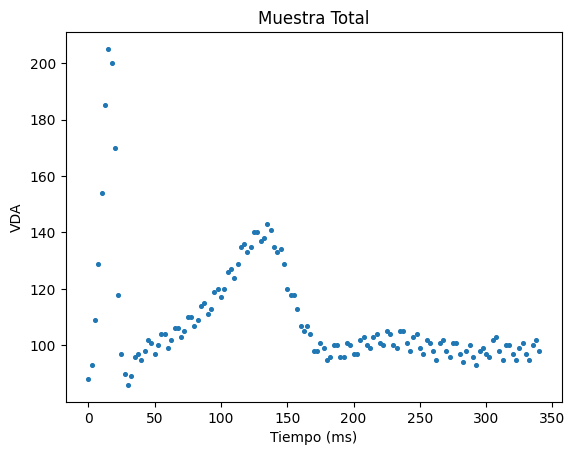

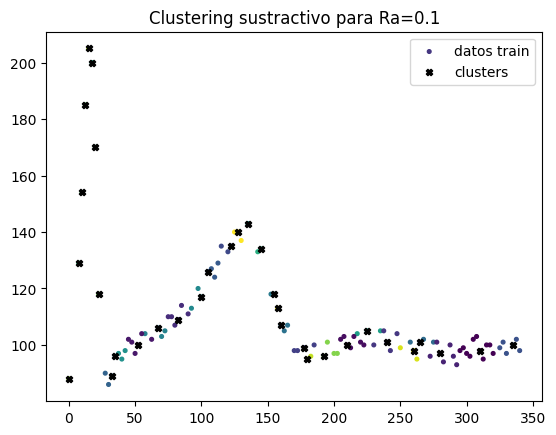

[-1.68730327e+09 -2.72833255e+07 -4.15600197e+10 -4.99281509e+06
  2.72982802e+10  7.53249105e+05  6.22342990e+09  5.37246117e+06
  1.55326112e+08  1.60773333e+07  1.31000958e+10  4.95430132e+06
  1.88759763e+10 -1.42563248e+07 -1.44802929e+10  1.05134795e+07
  4.41304540e+09 -1.38894710e+07  1.15742323e+10 -1.00984794e+06
 -2.98874256e+09  7.82763669e+06  2.03713818e+10  2.57533225e+06
 -1.34243277e+10  5.83756529e+06 -2.18738950e+10  1.77063031e+07
 -2.35262555e+08  1.14316811e+07 -1.23985809e+10 -1.12301301e+07
 -2.41275753e+10  1.09395131e+08 -2.13073718e+10 -6.62095491e+06
  1.53886021e+10 -2.71809681e+07  2.76294805e+10  1.11068574e+07
 -2.19302034e+10 -2.51867727e+08  1.19226773e+10  2.16104615e+07
 -1.98768909e+10 -7.83687474e+06  1.40189311e+10 -3.86623771e+07
  2.27605529e+10  2.30383688e+07 -1.94504948e+10 -2.65382875e+07
  1.15062390e+10 -2.02917544e+07 -3.36366416e+10  1.77213764e+06
 -2.57133951e+10 -8.45122948e+05  2.56459285e+10  8.57400310e+05
  2.54680300e+10 -2.00349

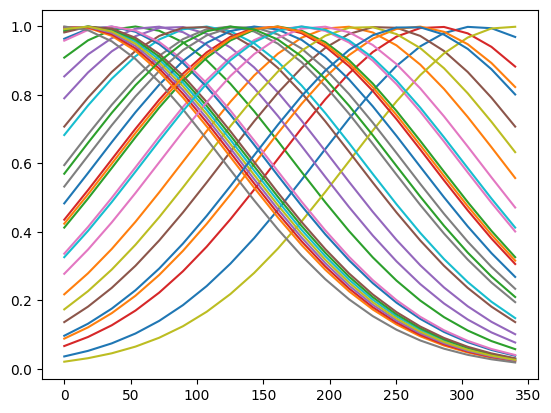

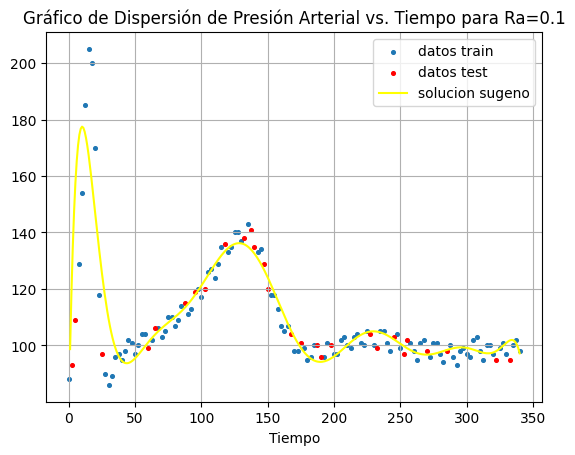

Error promedio: 6.524468022498955
[4.76238541788245]


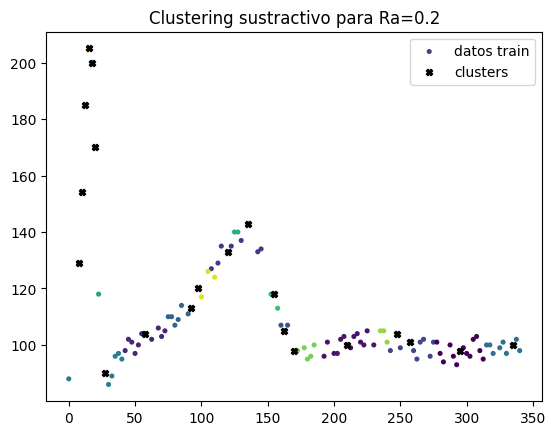

[ 5.71500882e+08 -1.03282954e+12 -4.52809388e+10  4.94142950e+10
 -3.31093675e+09 -7.04869121e+10  1.93725893e+11 -3.24880402e+10
  9.14895128e+10  7.20655945e+10 -8.89887993e+10  7.28370644e+10
  1.42251163e+10 -7.19710356e+09  1.97138435e+10 -1.67119596e+11
  3.91551833e+09  7.26640991e+10 -1.77701719e+11  7.23651719e+10
  1.35718199e+08 -1.03282937e+12 -4.52900918e+10  4.94145615e+10
 -3.31183952e+09 -7.04869120e+10  1.93725899e+11 -3.24880402e+10
  9.14895113e+10  7.20655945e+10 -8.89887993e+10  7.28370644e+10
  1.42251163e+10 -7.19710356e+09  1.97138435e+10 -1.67119596e+11
  3.91551833e+09  7.26666085e+10 -1.79619713e+11  7.23649190e+10]
 error en ierror0, error:  [-6.08654785] , resultado_obtenido = 93.9134521484375, resultado_esperado = [100.]
 error en ierror1, error:  [7.34283447] , resultado_obtenido = 102.34283447265625, resultado_esperado = [95.]
 error en ierror2, error:  [2.78527832] , resultado_obtenido = 122.7852783203125, resultado_esperado = [120.]
 error en ierror3, 

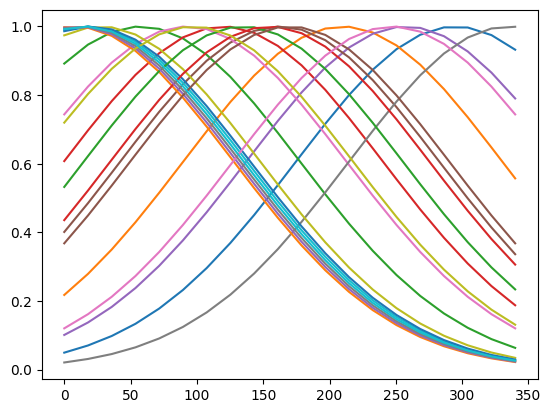

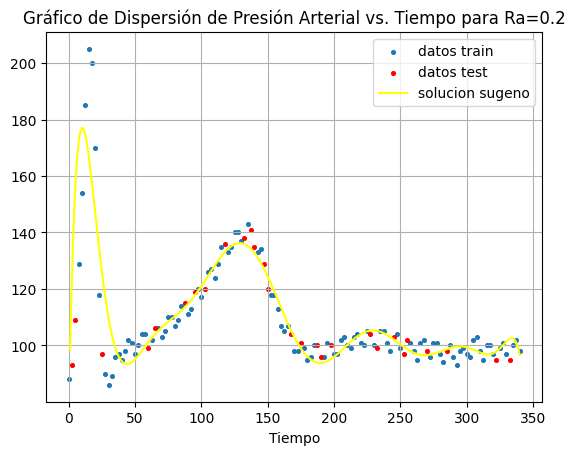

Error promedio: 6.56500632422311
[4.76238541788245, 4.7919754191409565]


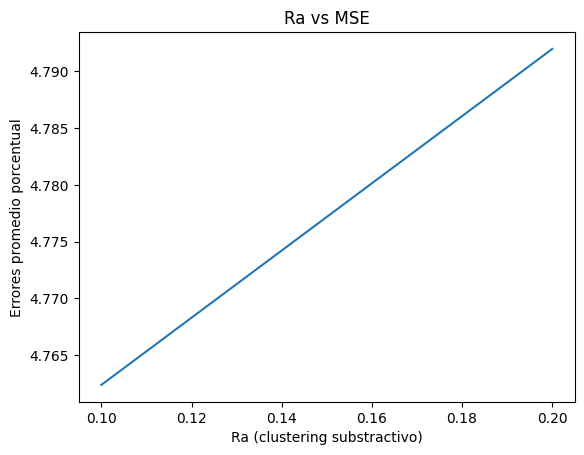

(137, 1)
X después de RandomOverSampler:
(517, 1)
---------------------
(137, 1)
y después de Random
(517,)
(517, 1)


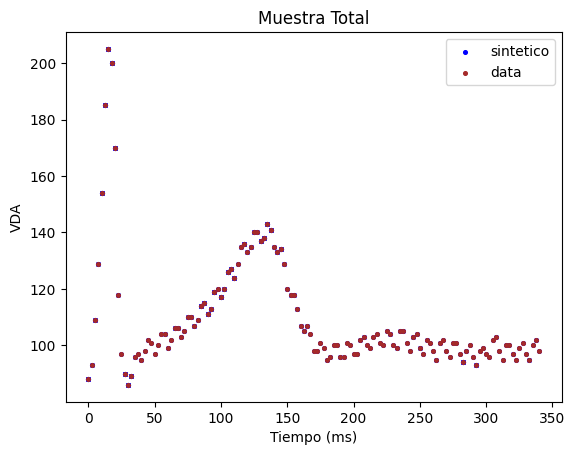

In [94]:
'''                                 MODULO DE LECTURA DE ARCHIVO                                      '''

from sklearn.model_selection import train_test_split
import numpy as np

# Cargar los datos desde el archivo de texto
vda = np.loadtxt("/home/mikel/Documents/Facultad/IA/tp-ia/samplesVDA2.txt")
cant_datos = vda.shape[0]
medidas_x_segundo = 400 
npyarray=np.array
tiempo = np.arange(0,cant_datos/400,1/medidas_x_segundo)
tiempo = tiempo*1000

data_y = vda.reshape(-1,1) 
data_x = tiempo.reshape(-1,1)

dataGral=np.hstack((data_y,data_x))

#Graficamos los datos totales
plt.scatter(data_x, data_y,s=7)
plt.xlabel('Tiempo (ms)')
plt.ylabel('VDA')
plt.title('Muestra Total')
plt.show()

errores_totales=[]
vectorRa=[]
Ra=0
for i in range (0,2):
    Ra+=0.1
    vectorRa.append(Ra)
    errores_totales.append(automation(data_x,data_y,0.2,Ra,0))
    print(errores_totales)

plt.figure()
plt.plot(vectorRa, errores_totales)
plt.ylabel('Errores promedio porcentual')
plt.xlabel('Ra (clustering substractivo)')
plt.title('Ra vs MSE')
plt.show()

# Crear una instancia de RandomOverSampler
ros = RandomOverSampler(random_state=10)

# Aplicar RandomOverSampler para sobremuestrear los datos
X_resampled, y_resampled = ros.fit_resample(data_x, data_y)


print(data_x.shape)
print("X después de RandomOverSampler:")
print(X_resampled.shape)
print("---------------------")
print(data_y.shape)
print("y después de Random")
print(y_resampled.shape)

y_resampled2=y_resampled.reshape(-1,1)

print(y_resampled2.shape)

plt.figure()
plt.scatter(X_resampled, y_resampled2,s=7,c='blue',label='sintetico')
plt.scatter(data_x,data_y,s=7,c='brown',label='data')
plt.xlabel('Tiempo (ms)')
plt.ylabel('VDA')
plt.title('Muestra Total')
plt.legend()
plt.show()


In [49]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Datos de ejemplo (variables predictoras X y variable objetivo y)
X = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [10, 11], [11, 12]])
y = np.array([0, 0, 0, 0, 1, 1])  # Clases (0: clase minoritaria, 1: clase mayoritaria)


oversample = RandomOverSampler(sampling_strategy='minority')

# Crear una instancia de SMOTE con parámetros personalizados
smote = SMOTE(sampling_strategy='minority', k_neighbors=1, n_jobs=-1, random_state=42)

# Aplicar SMOTE para sobremuestrear los datos
X_resampled, y_resampled = smote.fit_resample(X, y)

print("X después de SMOTE:")
print(X_resampled)
print("y después de SMOTE:")
print(y_resampled)
print(X.shape)
print(X_resampled.shape)

X después de SMOTE:
[[ 1  2]
 [ 2  3]
 [ 3  4]
 [ 4  5]
 [10 11]
 [11 12]
 [10 11]
 [10 11]]
y después de SMOTE:
[0 0 0 0 1 1 1 1]
(6, 2)
(8, 2)


/home/mikel/Documents/Facultad/IA/IA/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [75]:
# Dos arreglos
arr1 = [1, 2, 3, 4, 5]
arr2 = [3, 4, 5, 6, 7]

# Eliminar elementos de arr1 que están también en arr2
arr1_sin_interseccion = [elemento for elemento in arr1 if elemento not in arr2]

print("arr1 después de eliminar elementos comunes con arr2:", arr1_sin_interseccion)

arr1 después de eliminar elementos comunes con arr2: [1, 2]
